In [235]:

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import random

In [236]:
import math

class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        other_value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other_value.data, (self, other_value), '+')

        def _backward():
            self.grad += out.grad
            other_value.grad += out.grad
        out._backward = _backward

        return out

    
    def __mul__(self, other):
        other_value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other_value.data, (self, other_value), '*')

        def _backward():
            self.grad += other_value.data * out.grad
            other_value.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        other_value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other_value.data, (self, other_value), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other_value.grad += -1.0 * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        other_value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other_value.data, (self, other_value), '**')

        def _backward():
            self.grad += (other_value.data * self.data**(other_value.data-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


In [237]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [238]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        return act.tanh()

In [239]:
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        return [n(x) for n in self.neurons]
    
    def parameters(self):
        for n in self.neurons:
            yield n.b
            for w in n.w:
                yield w

In [240]:
class MLP:
    def __init__(self,sizes):
        self.layers = [Layer(nin,nout) for nin,nout in zip(sizes,sizes[1:])]
    
    def __call__(self,x):
        for layer in self.layers:
            x = [n(x) for n in layer.neurons]
        return x
    
    def parameters(self):
        for layer in self.layers:
            for p in layer.parameters():
                yield p
                

In [241]:
x = [2.0, 3.0, -1.0]
n = MLP([3,4,2,1])
n(x)

[Value(0.6510138851978037)]

In [242]:
# calculate the length of the parameter vector
n_params = sum(len(list(layer.parameters())) for layer in n.layers)
print(f"Number of parameters in the network: {n_params}")

Number of parameters in the network: 29


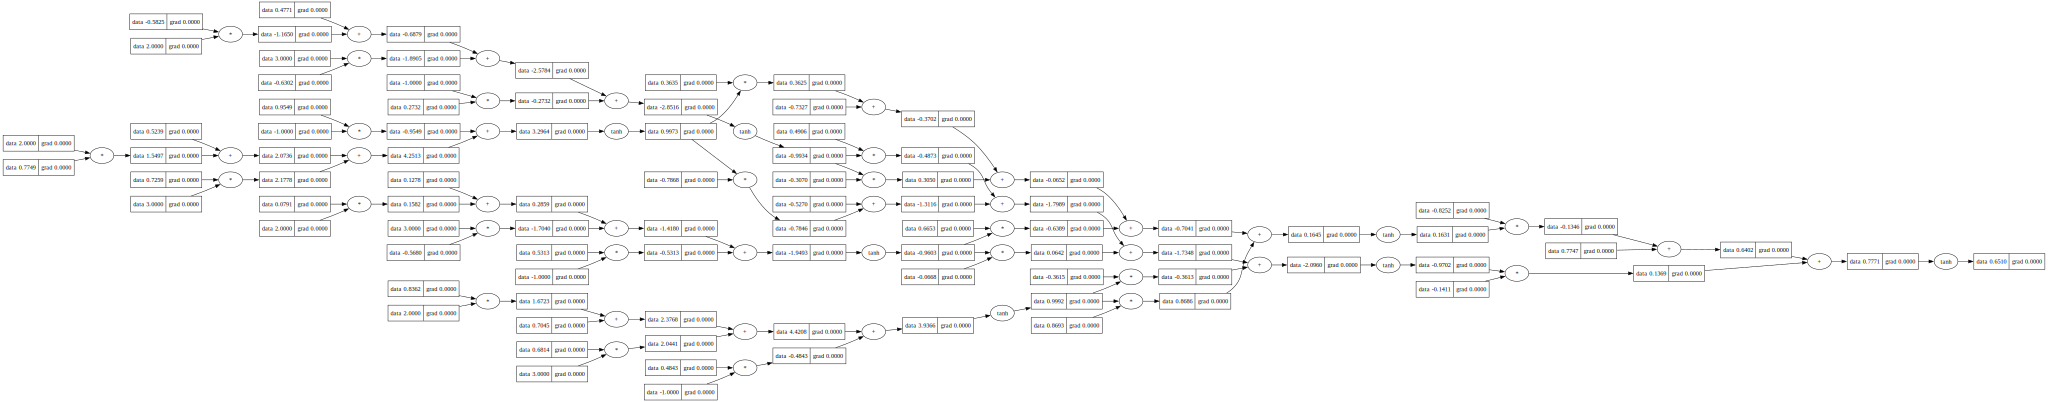

In [243]:
draw_dot(n(x)[0])

In [253]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 1.0],
    [-1.0, -1.0, -1.0],
    [1.0, 1.0, 1.0]
]
ys= [1.0, 0.0, 1.0, 0.0]
ypred = [n(x)[0] for x in xs]
ypred

[Value(0.8522772899404495),
 Value(-0.08307034325165144),
 Value(0.9395580679223968),
 Value(0.06073069213550101)]

In [254]:
for k in range(20):
    for x,y in zip(xs,ys):
        ypred = n(x)[0]
        loss = (ypred - y)**2
        loss.backward()
        for p in n.parameters():
            p.data -= 0.05*p.grad
            p.grad = 0.0
    print(f"Epoch {k}, Loss {loss.data}")

Epoch 0, Loss 0.00928786464811662
Epoch 1, Loss 0.008947841902836874
Epoch 2, Loss 0.008631495211393095
Epoch 3, Loss 0.008336406486048184
Epoch 4, Loss 0.008060486610260464
Epoch 5, Loss 0.007801919253206903
Epoch 6, Loss 0.007559116137617801
Epoch 7, Loss 0.007330681093619392
Epoch 8, Loss 0.007115380916990366
Epoch 9, Loss 0.006912121546097162
Epoch 10, Loss 0.006719928433446032
Epoch 11, Loss 0.0065379302538322095
Epoch 12, Loss 0.006365345288445522
Epoch 13, Loss 0.006201469971943109
Epoch 14, Loss 0.006045669200882847
Epoch 15, Loss 0.005897368086608619
Epoch 16, Loss 0.005756044900601313
Epoch 17, Loss 0.005621225010465616
Epoch 18, Loss 0.005492475643754499
Epoch 19, Loss 0.005369401347443776


In [255]:
ypred

Value(0.07327619905155955)

In [248]:
loss = [(n(x)[0] - y)**2 for x,y in zip(xs,ys)]
# add all the losses it in value
total_loss = sum(loss, Value(0.0))

In [249]:
total_loss

Value(0.15662897690108113)

In [250]:
total_loss.backward()

In [251]:
n.layers[0].neurons[0].w[0].grad

0.0005529794879495123

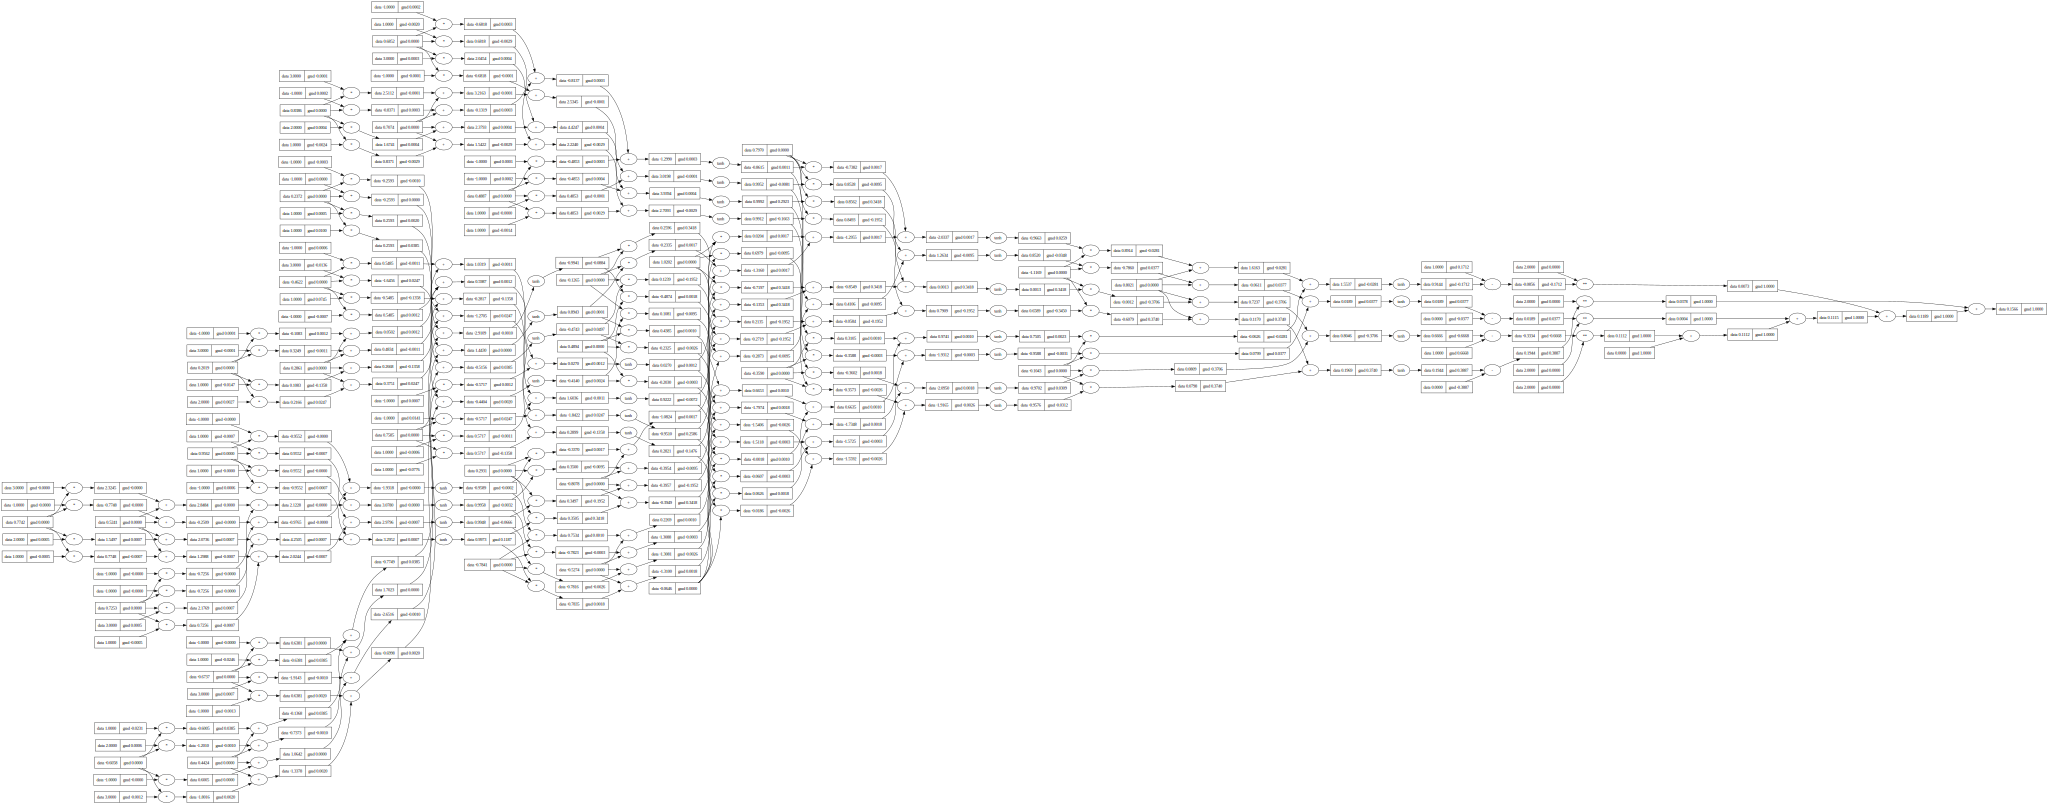

In [256]:
draw_dot(total_loss)